## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

date_info = data.groupby(['group'])['date'].min()
display(date_info)
date_info = data.groupby(['group'])['date'].max()
display(date_info)

group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

Вывод: периоды тестирования одинаковые с 2021-01-02 по 2021-01-24

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
# ваш код здесь
# Сгруппируем сразу таблицу с ответами
data_grouped = data.groupby(['group']).agg({'date':'count', 'purchase': 'sum', 'price': 'sum'})
data_grouped['price'] = data_grouped['price']/1000000
data_grouped

,date,purchase,price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
# ваш код здесь
# создаем множества пользователей обеих групп
users_A = set(data[data['group'] == 'A']['user_id'])
users_B = set(data[data['group'] == 'B']['user_id'])
users_intersection = users_A.intersection(users_B)
len(users_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

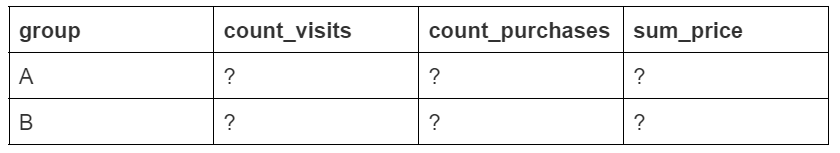
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
# ваш код здесь
data_grouped = updated_data.groupby(['group']).agg(
    {'date':'count', 'purchase': 'sum', 'price': 'sum'}
    ).rename(columns={'date':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
data_grouped

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь

Число посещений сопостовимо. Более того разница в 4 знаке, если поделить одно чилсо посещений на другой. На масштабе сотен тысяч - их почти поровну.
Еще момент: сама выборка большая, у нас больше 100000 наблюдений. Такой число наблюдений позволеет сделать достоверные выводы в большинстве случаев. КОроче, данных много - и это хорошо.
Можно делать анализ.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
# ваш код здесь
data_grouped['convertion'] = data_grouped['count_purchases'] / data_grouped['count_visits'] *100
data_grouped['mean_check'] = data_grouped['sum_price'] / data_grouped['count_purchases'] 
data_grouped

,count_visits,count_purchases,sum_price,convertion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсии очень близки, но в группе А чуть выше. Средний чек же заметно выше в группе В

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
# делаем сводную (таблицу берем только по данным с покупками,т.к. мы знаем, что больше всего пользоватлей, которые ничего не купили)
data_piv = pd.pivot_table(data = updated_data[updated_data['price'] > 0], values = 'date', index = 'group', columns='price', aggfunc='count')
data_piv


price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<Axes:xlabel='price', ylabel='group'>

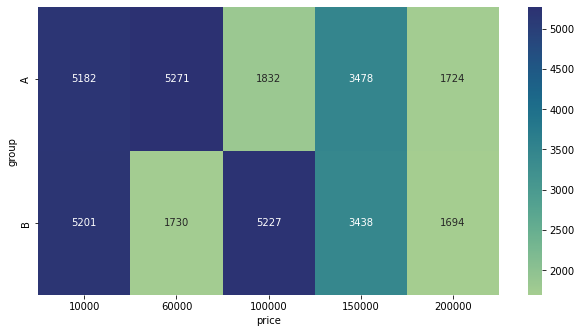

In [12]:
# рисуем тепловую карту
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(data=data_piv, annot = True, fmt=".0f",  cmap="crest")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Количество покупок примерно совпадает по ценам, кроме туров за 60000 и за 100000 руб.

В варианте А, у нас покупают более дешевые туры по 60000, а в варианте В более дорогие 10000.

И это существенная разница т.к. на итоговых данных при меньшей конверсии варианта В, средний чек варианта В заметно выше. И именно отсюда и идет этот эффект: у пользователей группы В выше покупательская способность по турам среднего ценового сегмента.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
# ваш код здесь
data_grouped_by_date = updated_data.groupby(['date','group']).agg(
    {'user_id':'count', 'purchase': 'sum', 'price': 'sum'}
    ).reset_index().rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
data_grouped_by_date['convertion'] = data_grouped_by_date['count_purchases'] / data_grouped_by_date['count_visits']*100
data_grouped_by_date['mean_check'] = data_grouped_by_date['sum_price'] / data_grouped_by_date['count_purchases']
data_grouped_by_date[data_grouped_by_date['date'] == '2021-01-03']

,date,group,count_visits,count_purchases,sum_price,convertion,mean_check
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
# ваш код здесь
# вычисляем кумулятивную сумму количества посещений
data_grouped_by_date['cum_count_visits'] = data_grouped_by_date.groupby(['group'])['count_visits'].cumsum()
# вычисляем кумулятивную сумму количества покупок
data_grouped_by_date['cum_count_purchases'] = data_grouped_by_date.groupby(['group'])['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
data_grouped_by_date['cum_sum_price'] = data_grouped_by_date.groupby(['group'])['sum_price'].cumsum()
# вычислим куммулятивную конверсию
data_grouped_by_date['cum_convertion'] = data_grouped_by_date['cum_count_purchases'] / data_grouped_by_date['cum_count_visits'] *100
# вычислим куммулятивный ср чек
data_grouped_by_date['cum_mean_check'] = data_grouped_by_date['cum_sum_price'] / data_grouped_by_date['cum_count_purchases']

display(data_grouped_by_date[data_grouped_by_date['date'] == '2021-01-20'])
display(data_grouped_by_date[data_grouped_by_date['date'] == '2021-01-12'])

,date,group,count_visits,count_purchases,sum_price,convertion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_convertion,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,11.983770,81010.232814
37,2021-01-20,B,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,11.895911,88776.214128


,date,group,count_visits,count_purchases,sum_price,convertion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_convertion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

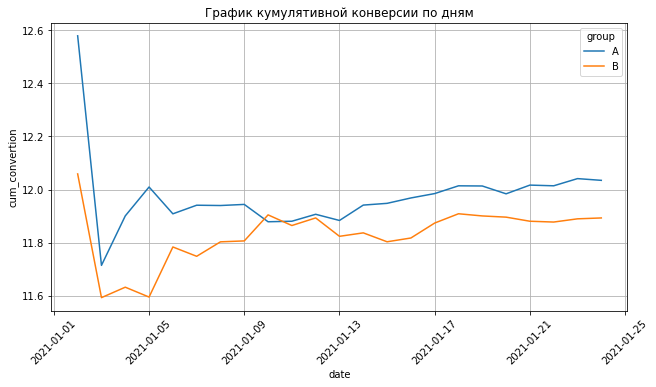

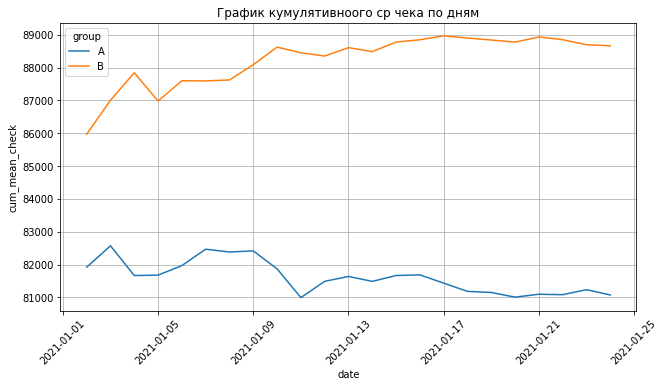

In [15]:
# ваш код здесь
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_convertion', data=data_grouped_by_date, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=data_grouped_by_date, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивноого ср чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Тесты можно назвать завершенными. Куммулятивная конверсия стабилизировалась примерно с 2021-01-17, как и куммулятивный срдний чек.

Что касается соотношения метрик:

* Куммулятивная конверсия в группе А почти все время, кроме периода с 2021-01-09 по 2021-01-10 выше. При стабилизации видно, что конверсия в группе А чуть лучше
* Куммулятивный средний чек всегда существенно лучше в группе В.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
display(data_grouped)

,count_visits,count_purchases,sum_price,convertion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


In [20]:
# буду использовать таблицу data_grouped, в ней уже вычислены суммы успехов и общие суммы наблюдений
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_grouped['count_purchases'], #число "успехов"
    nobs=data_grouped['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

С точки срения срезней конверсии варианты A и B одинаковы при alpha = 5%
Нет смысла внисить изменения от текщуго варианта А к тестовому вар ианту В только ради этого показателя.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [22]:
#напишем функцию определения доверительного интервала для пропорции
def proportions_conf_interval(n, x_p, gamma=0.95):   #n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95)
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

# Построим доверительные интервалы пропорции для каждой группы
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# Теперь возьмем функцию расчета доверительного интрервала для разницы конверсий

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

1. С одной стороны интервалы для А и В пересекаются (11.73 < 12.2), поэтому уже можно сказать, что статистический значимости между вариантами есть и подвтвердить вывод предыдущих заданий
2. С другой стороны это же подтверждается тем, что доверительный интервал для разницы конверсий содержит ноль

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [24]:
# ваш код здесь
data = data_grouped_by_date

H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data[data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(data[data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [33]:
# для нормального распределения на небольшом числе наблюдений ( а у нас < 30 наблюдений в каждой группе) будем использовать t-тест.
# Я буду использовать незавичимый t-тест т.к. у нас пользователи из разных совокупностей (они видели разные варианты на старте)
H0 = 'Ежедневные средние чеки равны в группах А и В'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе В'
alpha= 0.05

from scipy.stats import ttest_ind
test_results = ttest_ind(data[data['group'] == 'A']['mean_check'], data[data['group'] == 'B']['mean_check'])
p = round(test_results[1],2)

if p>alpha:
    print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}")



0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе В


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Статистическая разница есть. Средний чек в группе В выше, чем в А.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [40]:
from scipy.stats import t

n = data.shape[0]/2 # размер выборки. Наблюдений по дням в каждой группе как раз = числу строк таблицы пополам
k = n - 1 # число степеней свободы
x_mean_A = data[data['group'] == 'A']['mean_check'].mean() # выборочное среднее группы А
x_std_A = data[data['group'] == 'A']['mean_check'].std() # выборочное стандартное отклонение А
x_mean_B = data[data['group'] == 'B']['mean_check'].mean() # выборочное среднее группы А
x_std_B = data[data['group'] == 'B']['mean_check'].std() # выборочное стандартное отклонение А
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps_A = t_crit * x_std_A/(n ** 0.5) # погрешность
lower_bound = x_mean_A - eps_A # левая (нижняя) граница
upper_bound = x_mean_A + eps_A # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал среднего чека в группе А: {}'.format(confidence_interval)) # выводим результат

eps_B = t_crit * x_std_B/(n ** 0.5) # погрешность
lower_bound = x_mean_B - eps_B # левая (нижняя) граница
upper_bound = x_mean_B + eps_B # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал среднего чека в группе В: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал среднего чека в группе А: (79630, 82308)
Доверительный интервал среднего чека в группе В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

95% Интервалы групп А и В для среднего чека не пересекаются, более того B сильно правее (длина доверительного интервальных интервалов для среднего чека более чем вдвое меньше чем расстояние между интервалами).

Это значит что средний чек B существенно лучше, чем средний чек А

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**Замечание 1.** Надо четко понимать, что ввиду вводных данных мы считаем, что нам важно увеличить показатели и среднего чека и конверсии. Как ни странно, это не всегда может быть оправдано. Ведь, например, чисто гипотетически, на каждом туре наша фирма можети зарабатывать фиксированную суммы (не по выручке, а по прибыли), т.к. наценки на турах разные. И в этом случае нет никакого смысла увеличивать средний чек. Ввиду вышесказанного я далее буду считать, что на увеличение конверсии и среднего чека - это не параметры, которые мы ходим улучшить.

**Замечание 2.** В принципе, замечание 1 почти эквивалентно тому, что мы хотим увеличить общую сумму продаж. Правда для нее мы не проводили вычислений, однако, я позволю себе гипотезцу, что  статистически значимый средний чек + статистически незначимая конвесия = статистически значимые продажи в сумме.

Общий вывод такой:

1. Вариант В принимается ввиду того, что он позволяет привлекать аудиторию, которой интересны более дорогие туры в среднем сегменте (50000-100000 руб)
2. При этом дешевые (<50000 руб) и люксовые туры (>=150000) продаются в обоих вариантах примерно одинаково
3. Общее число покупок по варианте В примерно такое же, как во варианте А, однако за счет п.1 он дает большу сумму продаж.
4. % увеличесния продаж можно оценить как 8,2% (просто делим результаты выборки B в сумме на результыты выборки А, статистически уже проверено, что значимость есть)